In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline

データ読み込み

In [308]:
#カレントディレクトリの確認
print(os.getcwd())

#作業ディレクトリ設定
os.chdir(r'C:\Users\kajiw\Desktop\1_仕事\16_イベント登壇\DGLAB講座')

#カレントディレクトリ確認
print(os.getcwd())

#対象ファイルのパス取得
file_dir = os.getcwd()
file_name = 'supplemental.csv'
file_path = os.path.join(file_dir, file_name)
print('次のファイルを読み込みます : {}'.format(file_path))

#データ読み込み
df = pd.read_csv(file_path, engine = 'python')
print('{0}は{1}行、{2}変数です'.format(file_name, df.shape[0], df.shape[1]))


C:\Users\kajiw\Desktop\1_仕事\16_イベント登壇\DGLAB講座
C:\Users\kajiw\Desktop\1_仕事\16_イベント登壇\DGLAB講座
次のファイルを読み込みます : C:\Users\kajiw\Desktop\1_仕事\16_イベント登壇\DGLAB講座\supplemental.csv
supplemental.csvは569行、32変数です


データ基礎チェック

In [309]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,B,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [310]:
#id列は使用しないため削除
df = df.drop(['id'], axis = 1)

In [311]:
#目的変数確認
#もしそれぞれのクラスの数に片寄りがある場合は別途対処が必要
df['diagnosis'].value_counts()

B    357
M    208
Name: diagnosis, dtype: int64

In [312]:
#欠損値確認
df.isnull().sum()[df.isnull().sum() > 0]

diagnosis         4
perimeter_mean    1
radius_se         1
area_se           7
compactness_se    2
dtype: int64

In [313]:
#diagnosisが欠損のデータは削除する
mask = df['diagnosis'].isnull()
df = df.dropna(subset = ['diagnosis'], axis = 0)

In [314]:
print('diagnosis欠損削除後のデータ数 : {}件'.format(df.shape[0]))
print('\ndiagnosis欠損削除後の残った欠損値\n', df.isnull().sum()[df.isnull().sum() > 0])

diagnosis欠損削除後のデータ数 : 565件

diagnosis欠損削除後の残った欠損値
 perimeter_mean    1
radius_se         1
area_se           7
compactness_se    2
dtype: int64


In [315]:
#B, Mそれぞれでの各変数の平均値比較
df.groupby('diagnosis').mean()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,12.200137,17.925406,78.442157,468.190476,0.092479,0.080465,0.046910,0.026175,0.174042,0.062844,...,13.473050,23.543501,87.628852,569.993838,0.125232,0.183905,0.168360,0.075398,0.270327,0.079576
M,17.407163,21.641394,114.950918,973.105769,0.103122,0.145776,0.161114,0.087921,0.193605,0.062804,...,21.034471,29.351298,140.735913,1410.563462,0.144874,0.376121,0.451379,0.181701,0.324357,0.091637


In [316]:
#B, Mそれぞれでの各変数の標準偏差比較
df.groupby('diagnosis').std()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,1.876895,3.991166,12.459537,147.182959,0.013444,0.033881,0.044137,0.016657,0.024227,0.006743,...,2.220028,5.486847,15.047669,204.140152,0.020172,0.092259,0.141258,0.036958,0.041641,0.013799
M,3.264421,3.805181,22.329902,373.396203,0.012598,0.054216,0.075952,0.034932,0.028350,0.007624,...,4.358906,5.488425,30.027816,604.585761,0.021822,0.172059,0.184219,0.047723,0.074994,0.021725


In [317]:
#B,Mそれぞれでの基本統計量まとめて出力
df.groupby('diagnosis').describe()

area_mean                                                          \
              count        mean         std    min      25%    50%      75%   
diagnosis                                                                     
B             357.0  468.190476  147.182959  143.5  378.400  458.7   552.40   
M             208.0  973.105769  373.396203  311.9  701.125  929.1  1203.75   

                  area_se             ...   texture_se        texture_worst  \
              max   count       mean  ...          75%    max         count   
diagnosis                             ...                                     
B          1326.0   353.0  21.662601  ...        1.492  4.885         357.0   
M          2501.0   205.0  72.951659  ...        1.435  3.568         208.0   

                                                                       
                mean       std    min      25%     50%     75%    max  
diagnosis                                                              
B          23.543501  5.486847  12.02  19.5900  22.880  26.550  41.78  
M          29.351298  5.488425  16.67  25.7825  29.135  32.745  49.54  

[2 rows x 240 columns]

データ可視化

In [318]:
#スタイル設定
plt.style.use('ggplot')

#目的変数
target = df['diagnosis']

#説明変数
features = df.drop(['diagnosis'], axis = 1)

#説明変数の名前をリストとして取得
feature_names_list = list(features.columns)


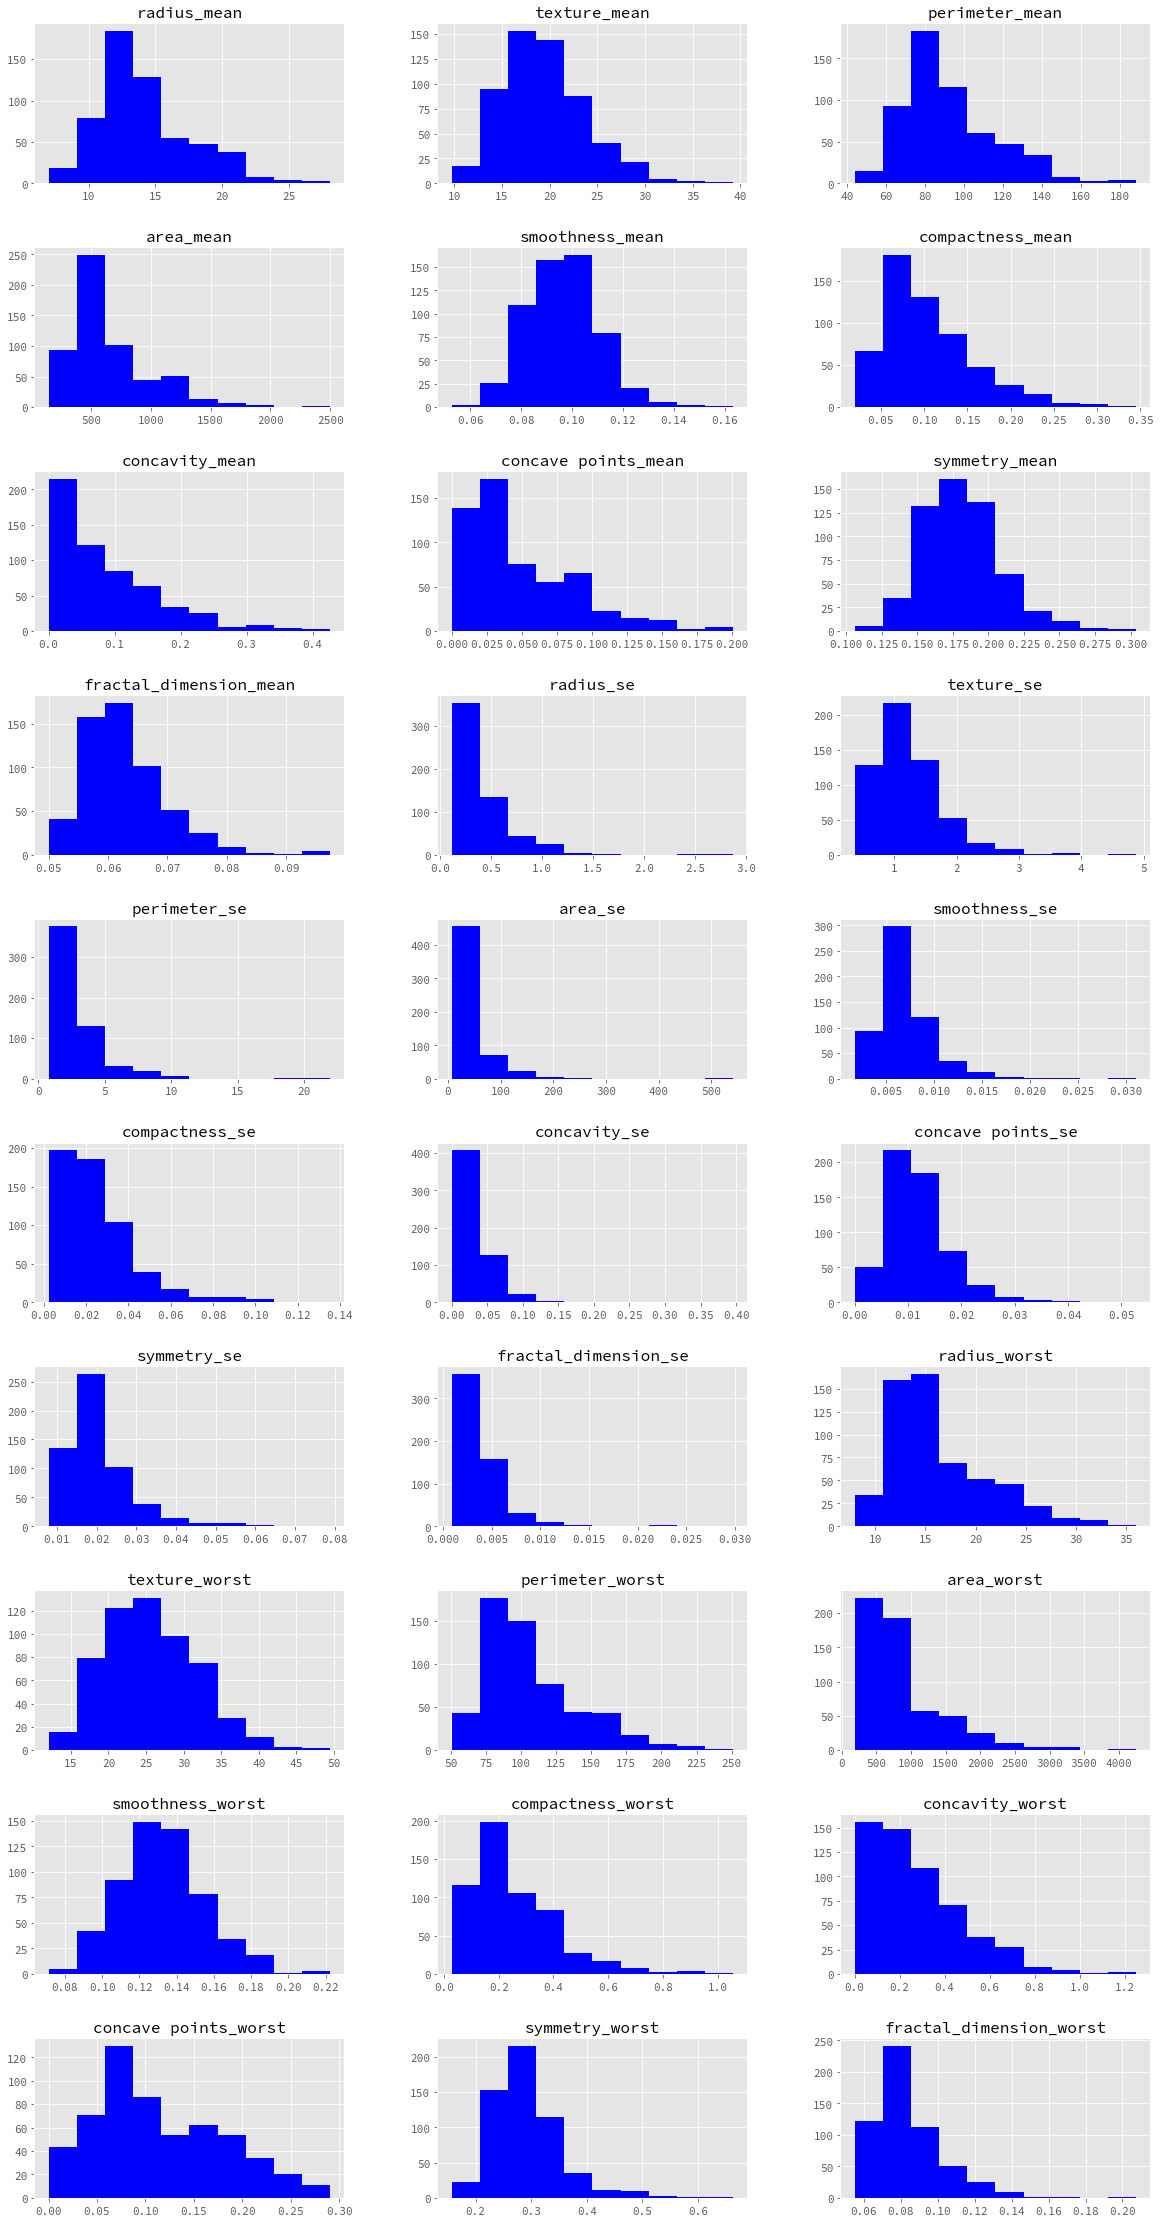

In [319]:
#----------------------------------
# 各変数のヒストグラム作成
#----------------------------------
plt.figure(figsize = (20, 40))
i = 1
for feature_name in feature_names_list:
    plt.subplot(10, 3, i)
    s = features[feature_name].dropna()
    plt.hist(s, color = 'b')
    plt.title(feature_name)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    i += 1
plt.show()


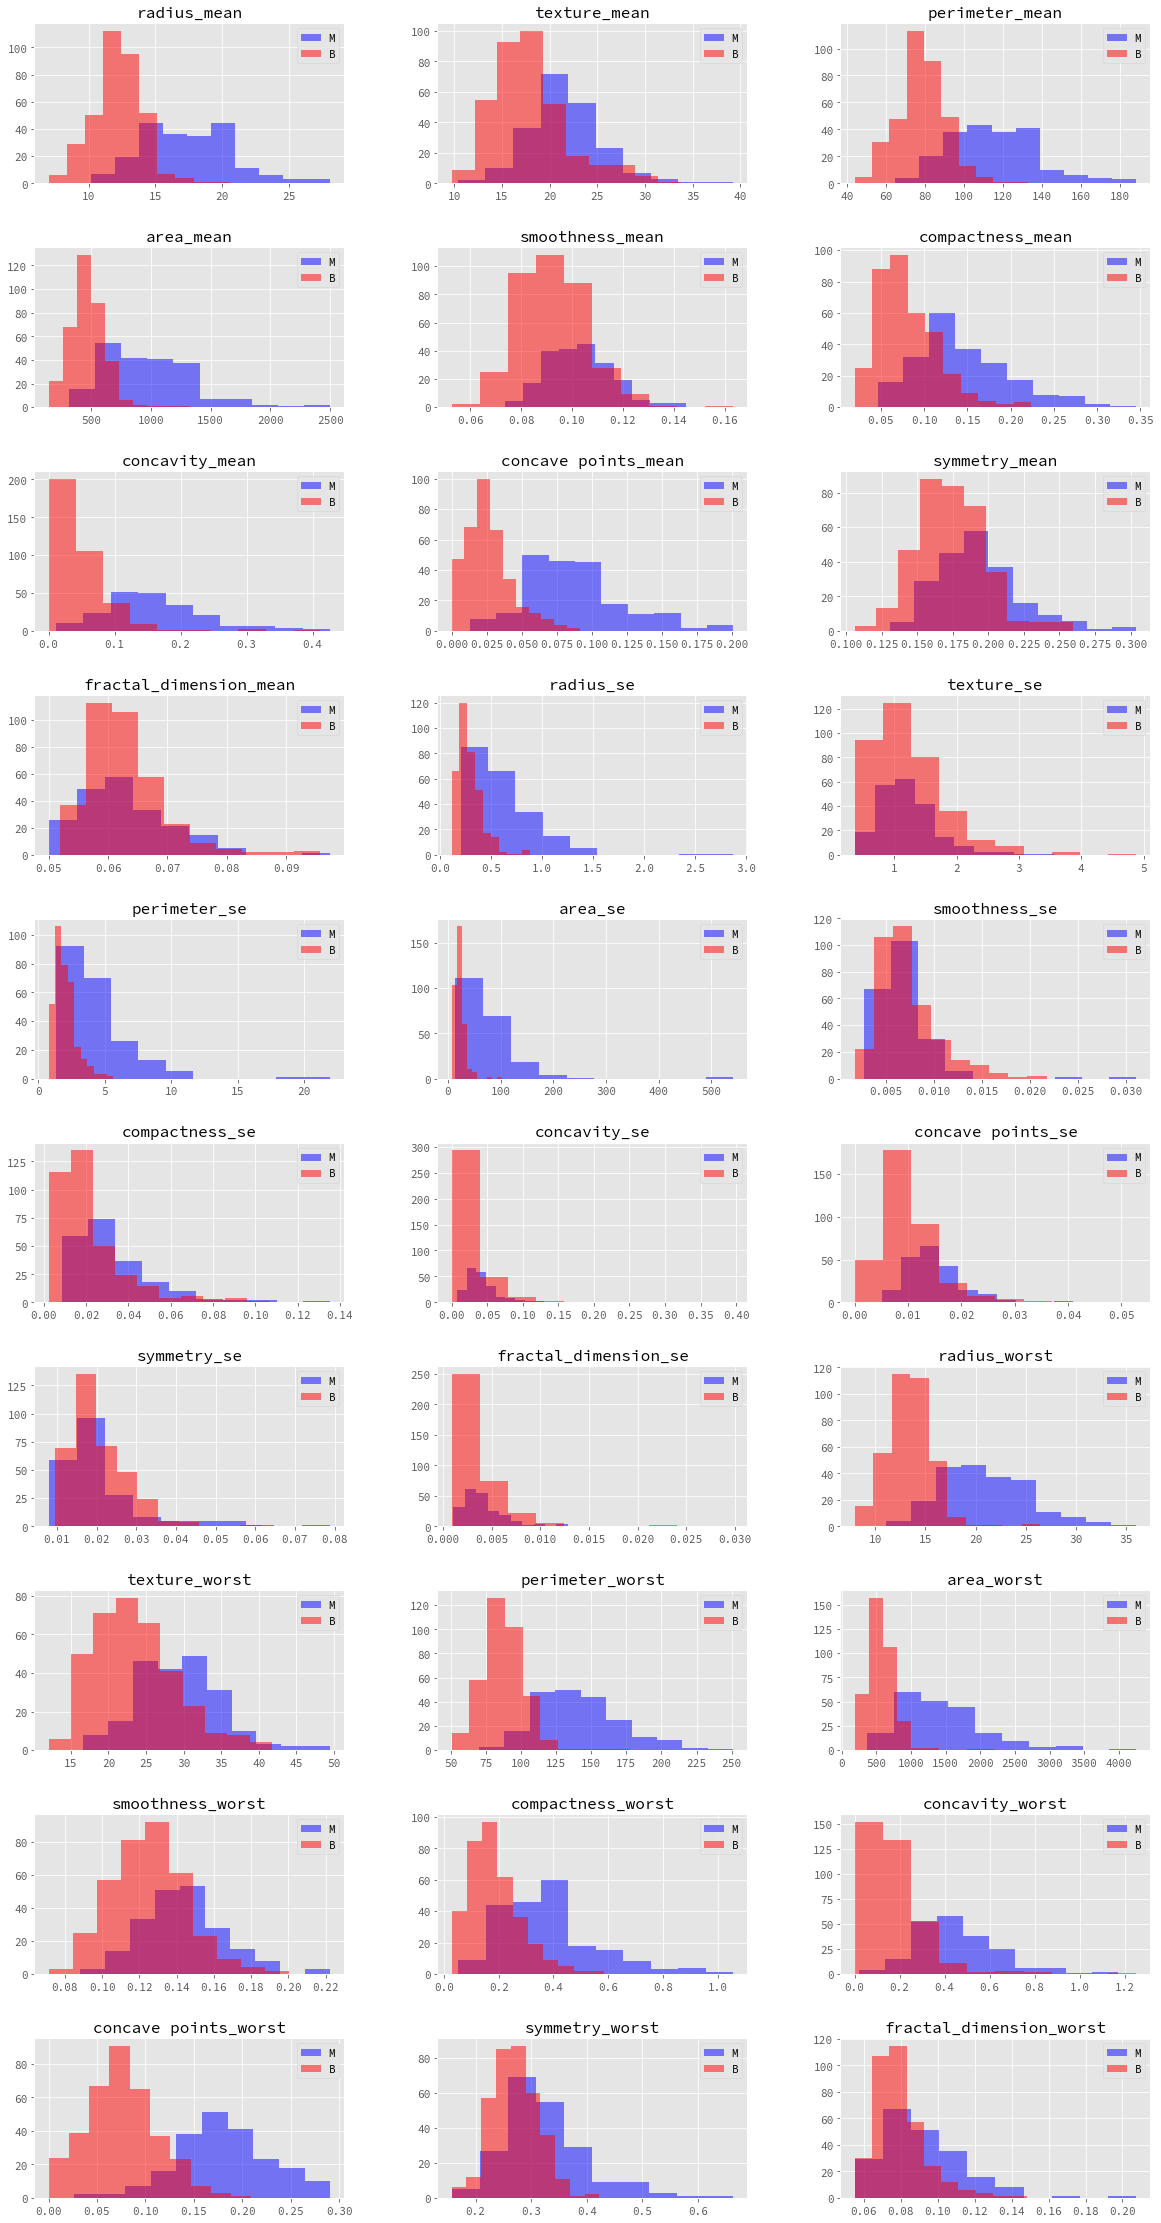

In [320]:
#---------------------------------------------------
# 目的変数による分布の違いをヒストグラムにより確認
#---------------------------------------------------
plt.figure(figsize = (20, 40))
i = 1
for feature_name in feature_names_list:
    plt.subplot(10, 3, i)
    df_temp = df.loc[:, [feature_name, 'diagnosis']].dropna(how = 'any', axis = 0)
    idx = np.where(df_temp['diagnosis'] == 'M', True, False)
    plt.hist(df_temp.loc[idx, feature_name], color = 'b', alpha = 0.5, label = 'M')
    plt.hist(df_temp.loc[~idx, feature_name], color = 'r', alpha = 0.5, label = 'B')
    plt.title(feature_name)
    plt.legend(loc = 'upper right')
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    i += 1
plt.show()

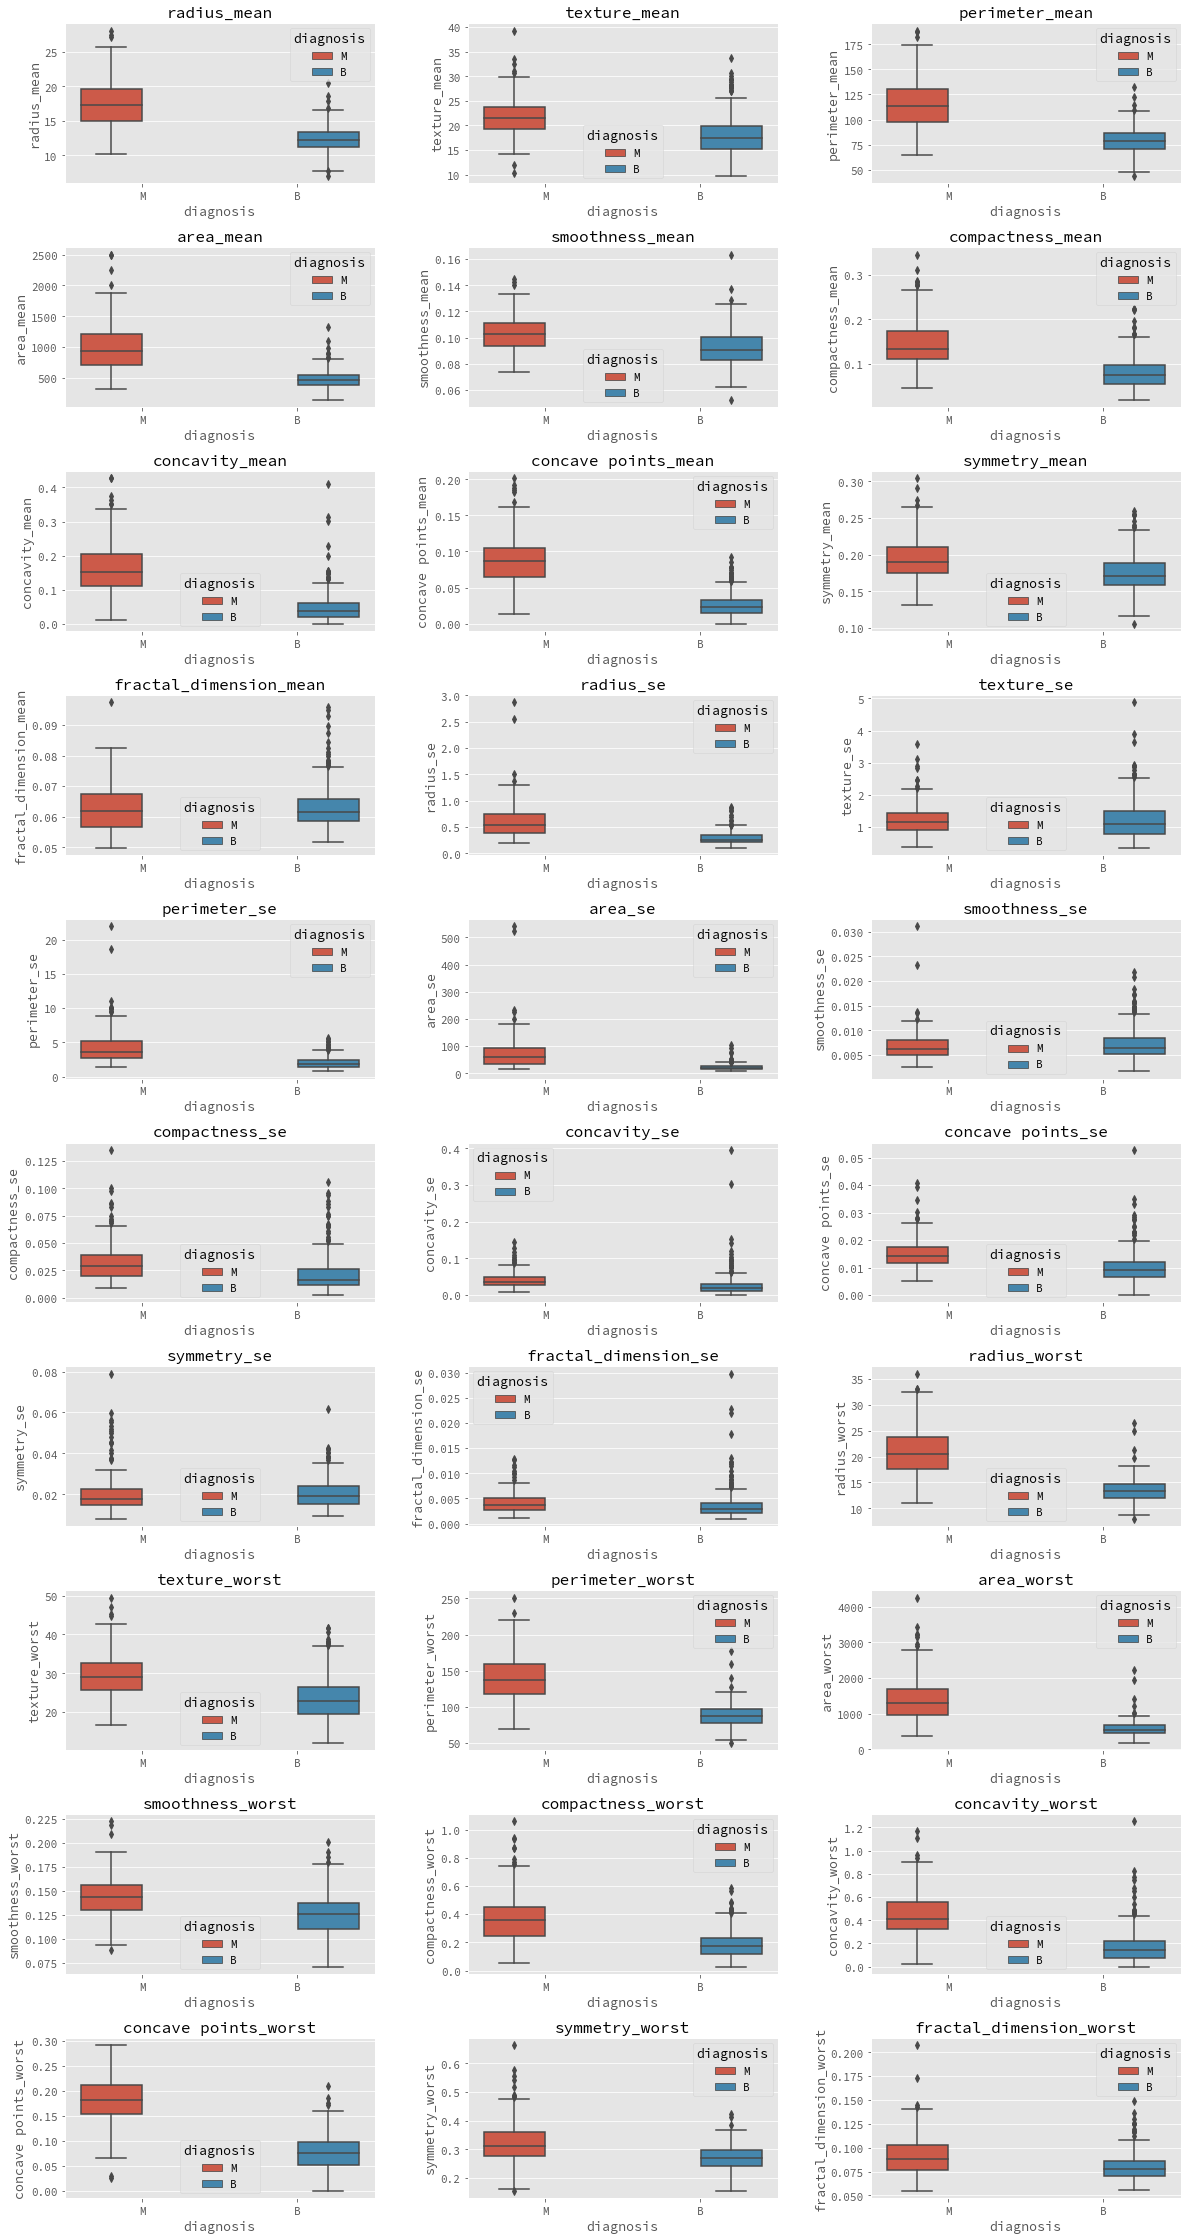

In [321]:
#----------------------------------------------
# 目的変数による分布の違いを箱ひげ図により確認
#----------------------------------------------
plt.figure(figsize = (20, 40))
i = 1
for feature_name in feature_names_list:
    plt.subplot(10, 3, i)
    df_temp = df.loc[:, [feature_name, 'diagnosis']].dropna(how = 'any', axis = 0)
    sns.boxplot(x = 'diagnosis', y = feature_name, data = df_temp, hue = 'diagnosis')
    plt.title(feature_name)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    i += 1
plt.show()

In [322]:
#------------------------------------------
# PCAによる次元圧縮を用いた可視化
#------------------------------------------

#欠損値除去
df_for_pca = df.dropna(how = 'any', axis = 0)

#説明変数のみ取得
X = df_for_pca.drop(['diagnosis'], axis = 1)
y = df_for_pca['diagnosis']


#標準化実行
#PCAの前は基本標準化する
#しないとスケールの大きい変数の結果が支配的になってしまう
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)

#PCA実行。可視化が目的なので3主成分まで圧縮。
pca = PCA(n_components=3, whiten = True)
X_pca = pca.fit_transform(X_scl)

#確認
print('PCA前のデータ : {}行 {}列'.format(X.shape[0], X.shape[1]))
print('PCA後のデータ : {}行 {}列'.format(X_pca.shape[0], X_pca.shape[1]))

PCA前のデータ : 555行 30列
PCA後のデータ : 555行 3列


In [323]:
#各主成分の寄与率
for i, exp_val in enumerate(pca.explained_variance_ratio_, 1):
    print('第{}主成分の寄与率 : {:.3f}'.format(i, exp_val))

print('累積寄与率 : {:.3f}'.format(pca.explained_variance_ratio_.sum()))

第1主成分の寄与率 : 0.440
第2主成分の寄与率 : 0.192
第3主成分の寄与率 : 0.095
累積寄与率 : 0.726


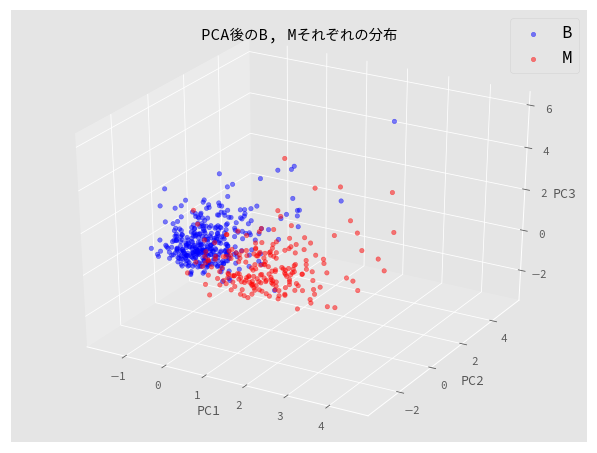

In [324]:
#可視化
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
idx = np.where(y == 'B', True, False)
ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], alpha = 0.5, color = 'b', label = 'B')
ax.scatter(X_pca[~idx, 0], X_pca[~idx, 1], X_pca[~idx, 2], alpha = 0.5, color = 'r', label = 'M')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA後のB, Mそれぞれの分布')
ax.legend(loc = 'upper right', fontsize = 16)
plt.show()

モデル作成前のデータ整形

In [325]:
#説明変数取得
X = df.drop(['diagnosis'], axis = 1).values

#目的変数を数値に変換
y = df['diagnosis'].map({'B':0, 'M':1}).values

#データを学習用・検証用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size = 0.25)


In [326]:
#欠損は各変数の平均値で補完
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [327]:
#標準化
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_imp)
X_test_scl = scaler.transform(X_test_imp)


モデル作成

In [328]:
#モデル作成の流れを理解するために、パラメータはチューニングせずにモデル作成
svm = SVC(kernel = 'rbf', gamma = 0.2, C = 1.0)

#訓練用データで学習
svm.fit(X_train_scl, y_train)

#訓練、検証それぞれのデータで正解率算出
print('training accuracy : {:.3f}'.format(svm.score(X_train_scl, y_train)))
print('test     accuracy : {:.3f}'.format(svm.score(X_test_scl, y_test)))

#混同行列確認
y_pred_train = svm.predict(X_train_scl)
y_pred_test = svm.predict(X_test_scl)
confmat_train = confusion_matrix(y_true = y_train, y_pred = y_pred_train)
confmat_test = confusion_matrix(y_true = y_test, y_pred = y_pred_test)
print('training confusion matrix : \n', confmat_train)
print('test confusion matrix : \n',confmat_test)

training accuracy : 0.993
test     accuracy : 0.915
training confusion matrix : 
 [[257   0]
 [  3 163]]
test confusion matrix : 
 [[90 10]
 [ 2 40]]


In [329]:
#-----------------------------------------
# パラメータチューニング実施
#-----------------------------------------

#gammaとCの2パラメータをチューニング
#Cを小さくすると正則化強くなる（複雑さを制限された状態）、Cを大きくすると正則化弱くなる（複雑さを許容）
#Gammaはガウシアンカーネルのパラメータ。Gammaが大きくなるとモデルはより複雑になる
#gammaを大きくするとガウシアンカーネルの直径が小さくなり、近いと感じるデータポイントの数が少なくなる

gamma_list = [0.01, 0.1, 1.0, 10, 100]
C_list = [0.01, 0.1, 1.0, 10, 100]

#最も良いモデルを判定するための指標として正解率を使用
#初期値を設定
best_accuracy = 0

#gamma, Cを変えながらベストな正解率を持つモデルを取得
for gamma in gamma_list:
    for C in C_list:
        svm = SVC(kernel = 'rbf', gamma = gamma, C = C, probability = True)
        svm.fit(X_train_scl, y_train)
        train_accuracy = svm.score(X_train_scl, y_train)
        test_accuracy  = svm.score(X_test_scl, y_test)
        print('-----------------------------------------------')
        print('gamma : {} C : {}\n train_accuracy = {:.3f} test_accuracy = {:.3f}'.format(gamma, C, train_accuracy, test_accuracy))
        if test_accuracy > best_accuracy:
            best_params = {'gamma':gamma, 'C':C}
            best_accuracy = test_accuracy
            best_model = svm

-----------------------------------------------
gamma : 0.01 C : 0.01
 train_accuracy = 0.608 test_accuracy = 0.704
-----------------------------------------------
gamma : 0.01 C : 0.1
 train_accuracy = 0.939 test_accuracy = 0.951
-----------------------------------------------
gamma : 0.01 C : 1.0
 train_accuracy = 0.962 test_accuracy = 0.972
-----------------------------------------------
gamma : 0.01 C : 10
 train_accuracy = 0.974 test_accuracy = 0.986
-----------------------------------------------
gamma : 0.01 C : 100
 train_accuracy = 0.988 test_accuracy = 0.979
-----------------------------------------------
gamma : 0.1 C : 0.01
 train_accuracy = 0.608 test_accuracy = 0.704
-----------------------------------------------
gamma : 0.1 C : 0.1
 train_accuracy = 0.943 test_accuracy = 0.923
-----------------------------------------------
gamma : 0.1 C : 1.0
 train_accuracy = 0.983 test_accuracy = 0.958
-----------------------------------------------
gamma : 0.1 C : 10
 train_accuracy

In [330]:
#ベストモデル確認
best_model

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

モデル性能検討

In [331]:
#-----------------------------
# 混同行列確認
#-----------------------------

#予測クラス取得
y_pred_train = best_model.predict(X_train_scl) 
y_pred_test = best_model.predict(X_test_scl)

#混同行列描画
conf_mat_train = confusion_matrix(y_true = y_train, y_pred = y_pred_train)
conf_mat_test = confusion_matrix(y_true = y_test, y_pred = y_pred_test)
print('training confusion matrix : \n', conf_mat_train)
print('test confusion matrix : \n', conf_mat_test)

training confusion matrix : 
 [[254   3]
 [  8 158]]
test confusion matrix : 
 [[100   0]
 [  2  40]]


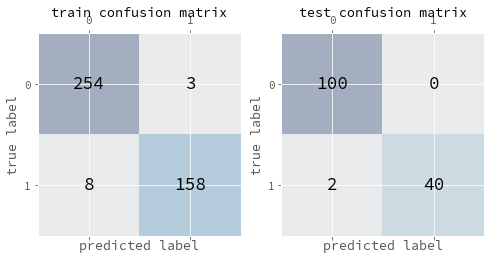

In [332]:
#---------------------------------------------
# (参考)一例として下記のような描きかたもできる
#---------------------------------------------
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
confmat_list = [conf_mat_train, conf_mat_test]
for k, conf_mat in enumerate(confmat_list):
    ax[k].matshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax[k].text(x = j, y = i, s = conf_mat[i, j], va = 'center', ha = 'center', fontsize = 16)
    ax[k].set_xlabel('predicted label')
    ax[k].set_ylabel('true label')
    if k == 0:
        ax[k].set_title('train confusion matrix', fontsize = 12)
    else:
        ax[k].set_title('test confusion matrix', fontsize = 12)
plt.show()

In [370]:
#----------------------------------------------
# ROC曲線描画関数定義
#----------------------------------------------

def draw_roc_curve(model, X_train, y_train, X_test, y_test):
        
    #ROC曲線描画
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    plt.plot(fpr_train, tpr_train, label = "Train AUC = {:.3f}".format(auc_train))

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr_test, tpr_test, label = "Test  AUC = {:.3f}".format(auc_test))
    plt.plot([0,1], [0, 1], color = 'navy', linestyle = '--')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc = 'lower right')
    plt.title('ROC Curve')
    plt.ylim(0, 1.05)
    plt.show()



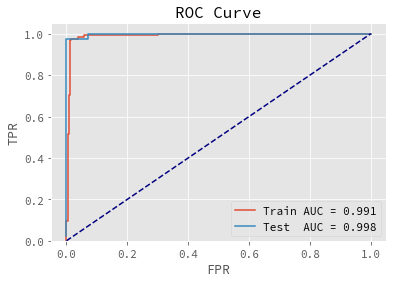

In [371]:
draw_roc_curve(best_model, X_train_scl, y_train, X_test_scl, y_test)

In [359]:
#predict_proba関数でモデルが出力した確率を取得できる
proba = best_model.predict_proba(X_test_scl)[:, 1]
df_proba = pd.DataFrame({'proba M' : proba, 'label':y_test})


In [360]:
df_proba.head()

,label,proba M
0,0,0.185119
1,0,0.017699
2,1,0.687450
3,0,0.002432
4,0,0.002831


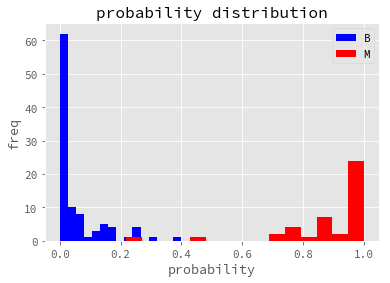

In [365]:
#モデルが予測したMである確率を本来がB,Mそれぞれで色をわけてヒストグラム描画
idx = np.where(df_proba['label'] == 0, True, False)
plt.hist(df_proba.loc[idx, 'proba M'], color = 'b', bins = 15, label = 'B')
plt.hist(df_proba.loc[~idx, 'proba M'], color = 'r', bins = 15, label = 'M')
plt.legend(loc = 'upper right')
plt.title('probability distribution')
plt.xlabel('probability')
plt.ylabel('freq')
plt.show()
